Neste notebook treinaremos modelos de classificação para prever o xG.

In [1]:
import time
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from mplsoccer import VerticalPitch
%matplotlib inline

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

#other
from aux_funcs import aux_functions_plot as p

#ml / stats

import sklearn.metrics as sk_metrics
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import lightgbm as lgb
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.layers import Dropout



2023-07-03 11:57:59.334493: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [32]:
def get_predictions_test_set(model = xgb_model, model_name = 'Modelo', X_test = X_test, y_test = y_test):

    """
    Recebe um modelo treinado através do parâmetro model e retorna as métricas de log-loss e AUC no dataset de teste.
    """

    pred_probs_model = model.predict_proba(X_test)[:,1]
    print(f"Log loss do {model_name} no dataset de teste: {sk_metrics.log_loss(y_test, pred_probs_model):.5f}")
    print(f"AUC do {model_name} no dataset de teste: {sk_metrics.roc_auc_score(y_test, pred_probs_model)*100:.2f}%")

## Modelagem

In [2]:
shots = pd.read_csv('./data/shots_dataframe_modelling.csv')

In [3]:
features = ['y', 'c', 'distance', 'angle',
       'free_kick', 'counter_attack', 'rebound', 'prev_cross', 'prev_touch',
       'prev_pass', 'prev_smart_pass', 'prev_duel'] # removemos x da lista de features devido à análise de multicolinearidade feita anteriormente

baseline_features = ['distance', 'angle']

target = ['goal']

In [4]:
X = shots[features]
X_baseline = shots[baseline_features]
y = shots[target]

Separando os dados em treino / teste

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

X_train_baseline, X_test_baseline, y_train_baseline, y_test_baseline = train_test_split(X_baseline, y, test_size=0.25, random_state=42)

In [6]:
len(y_test_baseline['goal'])

11316

In [7]:
y_test_baseline['goal'].sum()

1172

### Modelo baseline - Regressão Logística

In [8]:
lr_baseline = LogisticRegression(random_state=42)
lr_baseline.fit(X_train_baseline, np.array(y_train_baseline).ravel())

LogisticRegression(random_state=42)

In [9]:
pred_vals_baseline = lr_baseline.predict(X_test_baseline)

In [10]:
for i, col in enumerate(X_train_baseline.columns):
    print(f"Coeficiente da feature {col}: {lr_baseline.coef_[0][i]:.3f}")

Coeficiente da feature distance: -0.088
Coeficiente da feature angle: 1.373


In [11]:
pred_probs = lr_baseline.predict_proba(X_test_baseline)[:,1]
print(f"Log loss do modelo: {sk_metrics.log_loss(y_test_baseline, pred_probs):.5f}")
print(f"AUC do modelo: {sk_metrics.roc_auc_score(y_test_baseline, pred_probs)*100:.2f}%")

Log loss do modelo: 0.28693
AUC do modelo: 76.59%


In [12]:
# A titulo de comparação, caso tenhamos usado apenas a média para fazer a predição, a log-loss seria:

print(f"Log loss da média (0.1017, calculado anteriormente): {sk_metrics.log_loss(y_test, [0.1017]*len(y_test_baseline)):.3f}")

Log loss da média (0.1017, calculado anteriormente): 0.333


Nosso baseline é melhor do que usar a média para prever, o que é bom. Vamos agora usar validação cruzada e todas as features

### Regressão Logística - Testando todas as features + Scaling + CV

In [13]:
# Separando o dataset de treino em treino e validação para cross-validation
X_t, X_val, y_t, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=42)

In [14]:
lr = LogisticRegression(max_iter = 1000, random_state=42)

scaler = MinMaxScaler()

X_t_scaled = scaler.fit_transform(X_t)
X_val_scaled = scaler.fit_transform(X_val)

param_grid = {
                 'C': [0.3,0.5,0.8,1.0],
                 'solver': ['newton-cholesky', 'lbfgs'],
            }

grid_rf = GridSearchCV(lr, param_grid, cv=5, n_jobs = -1, scoring = 'neg_log_loss')
grid_rf.fit(X_t_scaled, np.array(y_t).ravel())

print(f"Training log-loss:{sk_metrics.log_loss(y_t, grid_rf.predict_proba(X_t_scaled))}")

print("\n")

print(f"Validation log-loss: {sk_metrics.log_loss(y_val, grid_rf.predict_proba(X_val_scaled))}")

print("\n")

print(f"Best parameters were:{grid_rf.best_params_}")

Training log-loss:0.2751922742734204


Validation log-loss: 0.2886638655357784


Best parameters were:{'C': 1.0, 'solver': 'newton-cholesky'}


Não parece haver overfitting, dado que o resultado de treino e validação são similares. Vamos ver o desempenho no hold-out.

In [15]:
X_train_scaled = scaler.fit_transform(X_train)
lr.fit(X_train_scaled, np.array(y_train).ravel())

LogisticRegression(max_iter=1000, random_state=42)

In [16]:
pred_vals_allfeatures = lr.predict(X_test)

In [17]:
X_test_scaled = scaler.fit_transform(X_test)
pred_probs = lr.predict_proba(X_test_scaled)[:,1]
print(f"Log loss do modelo: {sk_metrics.log_loss(y_test, pred_probs):.5f}")
print(f"AUC do modelo: {sk_metrics.roc_auc_score(y_test, pred_probs)*100:.2f}%")

Log loss do modelo: 0.28120
AUC do modelo: 77.93%


In [18]:
for i, col in enumerate(X_train.columns):
    print(f"Coeficiente da feature {col}: {lr.coef_[0][i]:.3f}")

Coeficiente da feature y: -0.221
Coeficiente da feature c: -0.315
Coeficiente da feature distance: -8.782
Coeficiente da feature angle: 4.644
Coeficiente da feature free_kick: 0.717
Coeficiente da feature counter_attack: 0.641
Coeficiente da feature rebound: 0.299
Coeficiente da feature prev_cross: -0.378
Coeficiente da feature prev_touch: 0.031
Coeficiente da feature prev_pass: -0.024
Coeficiente da feature prev_smart_pass: 0.403
Coeficiente da feature prev_duel: -0.442


### Random Forest

In [57]:
rf = RandomForestClassifier(criterion="log_loss")

param_grid = {
                 'n_estimators': [30,40,60],
                 'max_depth': [4,5,6,7,8,9,10],
                 'min_samples_split': [2,4,6,8]
            }

grid_rf = GridSearchCV(rf, param_grid, cv=5, n_jobs = -1, scoring = 'neg_log_loss')
grid_rf.fit(X_t, np.array(y_t).ravel())

print(f"Training log-loss:{sk_metrics.log_loss(y_t, grid_rf.predict_proba(X_t))}")

print("\n")

print(f"Validation log-loss: {sk_metrics.log_loss(y_val, grid_rf.predict_proba(X_val))}")

print("\n")

print(f"Best parameters were:{grid_rf.best_params_}")

Training log-loss:0.2652748645488553


Validation log-loss: 0.28779839439772237


Best parameters were:{'max_depth': 7, 'min_samples_split': 8, 'n_estimators': 60}


In [36]:
rf = RandomForestClassifier(max_depth=7, min_samples_split=4, n_estimators=60, criterion="log_loss")
rf.fit(X_train, np.array(y_train).ravel())

RandomForestClassifier(criterion='log_loss', max_depth=7, min_samples_split=4,
                       n_estimators=60)

In [37]:
get_predictions_test_set(model = rf, model_name = 'Modelo Random Forest', X_test = X_test, y_test = y_test)

Log loss do Modelo Random Forest no dataset de teste: 0.28068
AUC do Modelo Random Forest no dataset de teste: 78.22%


In [60]:
start_time = time.time()
result = permutation_importance(
    rf, X_val, y_val, n_repeats=10, random_state=42, n_jobs=-1
)
elapsed_time = time.time() - start_time
print(f"Tempo para computar as feature importances usando permutação: {elapsed_time:.3f} segundos")

forest_importances = pd.Series(result.importances_mean, index=features)

Tempo para computar as feature importances usando permutação: 1.886 segundos


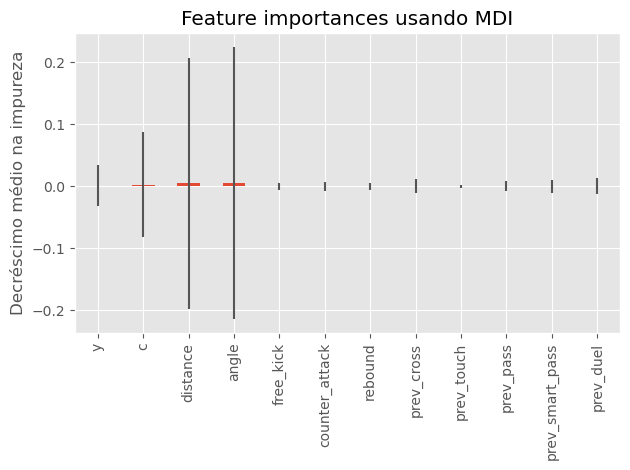

In [61]:
start_time = time.time()
importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)
elapsed_time = time.time() - start_time

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances usando MDI")
ax.set_ylabel("Decréscimo médio na impureza")
fig.tight_layout()

### XGBoost Classifier

In [19]:
# Define the parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [20,50,100, 200, 300],  
    'learning_rate': [0.05, 0.1, 0.3],  
    'max_depth': [3,6,9], 
    'colsample_bytree': [0.5, 1.0] 
}

# Create the XGBoost classifier
xgb_classifier = xgb.XGBClassifier()

grid_xgb = GridSearchCV(xgb_classifier, param_grid, cv=5, n_jobs = -1, scoring = 'neg_log_loss')
grid_xgb.fit(X_t, np.array(y_t).ravel())

print(f"Training log-loss:{sk_metrics.log_loss(y_t, grid_xgb.predict_proba(X_t))}")

print("\n")

print(f"Validation log-loss: {sk_metrics.log_loss(y_val, grid_xgb.predict_proba(X_val))}")

print("\n")

print(f"Best parameters were:{grid_xgb.best_params_}")


Training log-loss:0.2689153770367763


Validation log-loss: 0.2861990675224161


Best parameters were:{'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}


In [25]:
xgb_model = xgb.XGBClassifier(max_depth=3, learning_rate = 0.1 , n_estimators=100)
xgb_model.fit(X_train, np.array(y_train).ravel())


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [33]:
get_predictions_test_set(model = xgb_model, model_name = 'Modelo XGBoost', X_test = X_test, y_test = y_test)

Log loss do Modelo XGBoost no dataset de teste: 0.27931
AUC do Modelo XGBoost no dataset de teste: 78.32%


angle: 0.26982495188713074
distance: 0.25824666023254395
prev_duel: 0.1106359139084816
prev_smart_pass: 0.07978212088346481
prev_cross: 0.07006842643022537
prev_pass: 0.05557713657617569
counter_attack: 0.05010436102747917
free_kick: 0.04227573797106743
c: 0.024880198761820793
rebound: 0.02417703904211521
y: 0.014427359215915203
prev_touch: 0.0


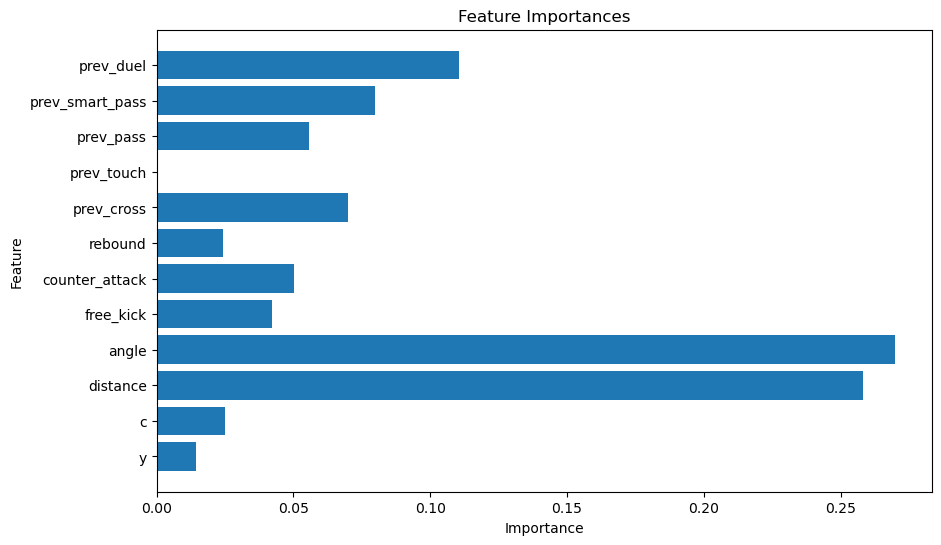

In [38]:
# Retrieve the feature importances
importances = xgb_model.feature_importances_

# Get the feature names
feature_names = xgb_model.get_booster().feature_names

# Create a dictionary with feature names and their importances
feature_importance_dict = dict(zip(feature_names, importances))

# Sort the feature importances in descending order
sorted_importances = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

# Print the feature importances
for feature, importance in sorted_importances:
    print(f"{feature}: {importance}")

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(range(len(importances)), importances, tick_label=feature_names)
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances')
plt.show()


### Light GBM

In [20]:
# Define the parameter grid for GridSearchCV
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'num_leaves': [14 ,31, 63, 127],
    'n_estimators': [20,50,100, 200, 300]
}

# Create the XGBoost classifier
lgb_classifier = lgb.LGBMClassifier()

grid_lgb = GridSearchCV(lgb_classifier, param_grid, cv=5, n_jobs = -1, scoring = 'neg_log_loss')
grid_lgb.fit(X_t, np.array(y_t).ravel())

print(f"Training log-loss:{sk_metrics.log_loss(y_t, grid_lgb.predict_proba(X_t))}")

print("\n")

print(f"Validation log-loss: {sk_metrics.log_loss(y_val, grid_lgb.predict_proba(X_val))}")

print("\n")

print(f"Best parameters were:{grid_lgb.best_params_}")


Training log-loss:0.27084880392850735


Validation log-loss: 0.2860316227405863


Best parameters were:{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50, 'num_leaves': 14}


In [28]:
lgb_model = lgb.LGBMClassifier(max_depth=3, learning_rate = 0.1 , n_estimators=50, num_leaves=14)
lgb_model.fit(X_train, np.array(y_train).ravel())

LGBMClassifier(max_depth=3, n_estimators=50, num_leaves=14)

In [34]:
get_predictions_test_set(model = lgb_model, model_name = 'Modelo LightGBM', X_test = X_test, y_test = y_test)

Log loss do Modelo LightGBM no dataset de teste: 0.27943
AUC do Modelo LightGBM no dataset de teste: 78.39%


### LSTM

In [30]:
# Reshape and adjust data type
X_t_lstm = X_t.values.reshape(X_t.shape[0], X_t.shape[1], 1).astype('float32')
X_val_lstm = X_val.values.reshape(X_val.shape[0], X_val.shape[1], 1).astype('float32')
X_test_lstm = X_test.values.reshape(X_test.shape[0], X_test.shape[1], 1).astype('float32')


In [31]:
# Define the LSTM model
model = Sequential()
model.add(LSTM(units=2))  # Specify the number of LSTM units/neurons
# Add any additional LSTM layers, if needed
model.add(Dense(units=1))  # Specify the number of units in the dense layer
# Add any additional dense layers, if needed
model.add(Dense(units=1, activation='sigmoid'))  # Output layer

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['binary_crossentropy'])

# Train the model
model.fit(X_t_lstm, y_t, epochs=10, batch_size=32, validation_data=(X_val_lstm, y_val))

# Evaluate the model on test data
loss, log_loss_test = model.evaluate(X_test_lstm, y_test)

print(f"Log loss of the test dataset is: {log_loss_test}")


Epoch 1/10
743/743 [==============================] - 6s 5ms/step - loss: 0.3889 - binary_crossentropy: 0.3889 - val_loss: 0.3366 - val_binary_crossentropy: 0.3366
Epoch 2/10
743/743 [==============================] - 2s 3ms/step - loss: 0.3204 - binary_crossentropy: 0.3204 - val_loss: 0.3310 - val_binary_crossentropy: 0.3310
Epoch 3/10
743/743 [==============================] - 2s 3ms/step - loss: 0.3127 - binary_crossentropy: 0.3127 - val_loss: 0.3181 - val_binary_crossentropy: 0.3181
Epoch 4/10
743/743 [==============================] - 3s 3ms/step - loss: 0.2971 - binary_crossentropy: 0.2971 - val_loss: 0.3016 - val_binary_crossentropy: 0.3016
Epoch 5/10
743/743 [==============================] - 2s 3ms/step - loss: 0.2888 - binary_crossentropy: 0.2888 - val_loss: 0.2998 - val_binary_crossentropy: 0.2998
Epoch 6/10
743/743 [==============================] - 2s 3ms/step - loss: 0.2875 - binary_crossentropy: 0.2875 - val_loss: 0.2982 - val_binary_crossentropy: 0.2982
Epoch 7/10
743/7

In [21]:
# Define the LSTM model
model = Sequential()
model.add(LSTM(units=4))  # Specify the number of LSTM units/neurons
# Add any additional LSTM layers, if needed
model.add(Dense(units=1))  # Specify the number of units in the dense layer
# Add any additional dense layers, if needed
model.add(Dense(units=1, activation='sigmoid'))  # Output layer

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['binary_crossentropy'])

# Train the model
model.fit(X_t_lstm, y_t, epochs=10, batch_size=32, validation_data=(X_val_lstm, y_val))

# Evaluate the model on test data
loss, log_loss_test = model.evaluate(X_test_lstm, y_test)

print(f"Log loss of the test dataset is: {log_loss_test}")


2023-07-03 13:29:15.813926: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/10
743/743 [==============================] - 7s 5ms/step - loss: 0.3411 - binary_crossentropy: 0.3411 - val_loss: 0.3007 - val_binary_crossentropy: 0.3007
Epoch 2/10
743/743 [==============================] - 3s 4ms/step - loss: 0.2864 - binary_crossentropy: 0.2864 - val_loss: 0.2979 - val_binary_crossentropy: 0.2979
Epoch 3/10
743/743 [==============================] - 3s 4ms/step - loss: 0.2851 - binary_crossentropy: 0.2851 - val_loss: 0.2972 - val_binary_crossentropy: 0.2972
Epoch 4/10
743/743 [==============================] - 2s 3ms/step - loss: 0.2843 - binary_crossentropy: 0.2843 - val_loss: 0.2959 - val_binary_crossentropy: 0.2959
Epoch 5/10
743/743 [==============================] - 3s 5ms/step - loss: 0.2839 - binary_crossentropy: 0.2839 - val_loss: 0.2976 - val_binary_crossentropy: 0.2976
Epoch 6/10
743/743 [==============================] - 3s 4ms/step - loss: 0.2834 - binary_crossentropy: 0.2834 - val_loss: 0.2941 - val_binary_crossentropy: 0.2941
Epoch 7/10
743/7

In [22]:

# Define the LSTM model
model = Sequential()
model.add(LSTM(units=8))  # Specify the number of LSTM units/neurons
# Add any additional LSTM layers, if needed
model.add(Dense(units=2))  # Specify the number of units in the dense layer
# Add any additional dense layers, if needed
model.add(Dense(units=1, activation='sigmoid'))  # Output layer

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['binary_crossentropy'])

# Train the model
model.fit(X_t_lstm, y_t, epochs=10, batch_size=32, validation_data=(X_val_lstm, y_val))

# Evaluate the model on test data
loss, log_loss_test = model.evaluate(X_test_lstm, y_test)

print(f"Log loss of the test dataset is: {log_loss_test}")


Epoch 1/10
743/743 [==============================] - 5s 4ms/step - loss: 0.3532 - binary_crossentropy: 0.3532 - val_loss: 0.2961 - val_binary_crossentropy: 0.2961
Epoch 2/10
743/743 [==============================] - 3s 4ms/step - loss: 0.2851 - binary_crossentropy: 0.2851 - val_loss: 0.2968 - val_binary_crossentropy: 0.2968
Epoch 3/10
743/743 [==============================] - 3s 4ms/step - loss: 0.2845 - binary_crossentropy: 0.2845 - val_loss: 0.2949 - val_binary_crossentropy: 0.2949
Epoch 4/10
743/743 [==============================] - 3s 3ms/step - loss: 0.2831 - binary_crossentropy: 0.2831 - val_loss: 0.2968 - val_binary_crossentropy: 0.2968
Epoch 5/10
743/743 [==============================] - 3s 4ms/step - loss: 0.2819 - binary_crossentropy: 0.2819 - val_loss: 0.2918 - val_binary_crossentropy: 0.2918
Epoch 6/10
743/743 [==============================] - 2s 3ms/step - loss: 0.2810 - binary_crossentropy: 0.2810 - val_loss: 0.2948 - val_binary_crossentropy: 0.2948
Epoch 7/10
743/7

In [23]:
# Define the LSTM model
model = Sequential()
model.add(LSTM(units=12))  # Specify the number of LSTM units/neurons
# Add any additional LSTM layers, if needed
model.add(Dropout(0.2))
model.add(Dense(units=4))  # Specify the number of units in the dense layer
# Add any additional dense layers, if needed
model.add(Dense(units=1, activation='sigmoid'))  # Output layer

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['binary_crossentropy'])

# Train the model
model.fit(X_t_lstm, y_t, epochs=10, batch_size=32, validation_data=(X_val_lstm, y_val))

# Evaluate the model on test data
loss, log_loss_test = model.evaluate(X_test_lstm, y_test)

print(f"Log loss of the test dataset is: {log_loss_test}")


Epoch 1/10
743/743 [==============================] - 6s 5ms/step - loss: 0.3238 - binary_crossentropy: 0.3238 - val_loss: 0.2968 - val_binary_crossentropy: 0.2968
Epoch 2/10
743/743 [==============================] - 3s 4ms/step - loss: 0.2892 - binary_crossentropy: 0.2892 - val_loss: 0.2956 - val_binary_crossentropy: 0.2956
Epoch 3/10
743/743 [==============================] - 3s 4ms/step - loss: 0.2873 - binary_crossentropy: 0.2873 - val_loss: 0.2966 - val_binary_crossentropy: 0.2966
Epoch 4/10
743/743 [==============================] - 3s 4ms/step - loss: 0.2860 - binary_crossentropy: 0.2860 - val_loss: 0.3055 - val_binary_crossentropy: 0.3055
Epoch 5/10
743/743 [==============================] - 3s 3ms/step - loss: 0.2854 - binary_crossentropy: 0.2854 - val_loss: 0.2939 - val_binary_crossentropy: 0.2939
Epoch 6/10
743/743 [==============================] - 3s 3ms/step - loss: 0.2839 - binary_crossentropy: 0.2839 - val_loss: 0.2949 - val_binary_crossentropy: 0.2949
Epoch 7/10
743/7